## Common Libraries

In [3]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import json, os, gzip
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.cluster import AgglomerativeClustering, MiniBatchKMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler, Normalizer
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.datasets import make_moons, make_circles, make_blobs

Constants

In [4]:
FIGURE_SAVE_PATH: str = "./figures"
TABLE_SAVE_PATH: str = "./table_results"
DATASET_PATH: str = "./datasets"
FILES:list[str] = ["dblp-ref-0.json", "dblp-ref-1.json", "dblp-ref-2.json", "dblp-ref-3.json"]

# Sampling length our dataset is too big this makes it more manageable to work with
# 2000 per year is a good representation of our dataset
DEV_MODE:bool = False
SAMPLES_PER_YEAR:int = 250 if DEV_MODE else 2000

### Load the Dataset

In [5]:
# loading data
def read_json_lines(path):
    with open(path, "r", encoding="utf-8") as f:
        for line in f:
            yield json.loads(line)

def load_all(files=FILES):
    rows = []
    for fp in files:
        for rec in read_json_lines(f"./datasets/{fp}"):
            rows.append(rec)
    return pd.DataFrame(rows)

df = load_all()

as_type = {
    "year": "category",
    "n_citation": np.uint32,
}

df = df.astype(as_type)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3079007 entries, 0 to 3079006
Data columns (total 8 columns):
 #   Column      Dtype   
---  ------      -----   
 0   abstract    object  
 1   authors     object  
 2   n_citation  uint32  
 3   references  object  
 4   title       object  
 5   venue       object  
 6   year        category
 7   id          object  
dtypes: category(1), object(6), uint32(1)
memory usage: 155.6+ MB


In [6]:
df.head(10)

,abstract,authors,n_citation,references,title,venue,year,id
0,The purpose of this study is to develop a lear...,"[Makoto Satoh, Ryo Muramatsu, Mizue Kayama, Ka...",0,"[51c7e02e-f5ed-431a-8cf5-f761f266d4be, 69b625b...",Preliminary Design of a Network Protocol Learn...,international conference on human-computer int...,2013,00127ee2-cb05-48ce-bc49-9de556b93346
1,This paper describes the design and implementa...,"[Gareth Beale, Graeme Earl]",50,"[10482dd3-4642-4193-842f-85f3b70fcf65, 3133714...",A methodology for the physically accurate visu...,visual analytics science and technology,2011,001c58d3-26ad-46b3-ab3a-c1e557d16821
2,This article applied GARCH model instead AR or...,"[Altaf Hossain, Faisal Zaman, Mohammed Nasser,...",50,"[2d84c0f2-e656-4ce7-b018-90eda1c132fe, a083a1b...","Comparison of GARCH, Neural Network and Suppor...",pattern recognition and machine intelligence,2009,001c8744-73c4-4b04-9364-22d31a10dbf1
3,NaN,"[Jea-Bum Park, Byungmok Kim, Jian Shen, Sun-Yo...",0,"[8c78e4b0-632b-4293-b491-85b1976675e6, 9cdc54f...",Development of Remote Monitoring and Control D...,,2011,00338203-9eb3-40c5-9f31-cbac73a519ec
4,NaN,"[Giovanna Guerrini, Isabella Merlo]",2,NaN,Reasonig about Set-Oriented Methods in Object ...,,1998,0040b022-1472-4f70-a753-74832df65266
5,NaN,"[Rafael Álvarez, Leandro Tortosa, José-Francis...",0,NaN,COMPARING GNG3D AND QUADRIC ERROR METRICS METH...,international conference on computer graphics ...,2009,005ce28f-ed77-4e97-afdc-a296137186a1
6,NaN,"[Jovan Dj. Golic, Guglielmo Morgari]",2,NaN,Vectorial fast correlation attacks.,,2004,00638a94-23bf-4fa6-b5ce-40d799c65da7
7,NaN,"[Guzin Ulutas, Mustafa Ulutas, Vasif V. Nabiyev]",0,"[5626736c-e434-4e2d-8405-54940fab88ab, 8e87e87...",Improved Secret Image Sharing Method By Encodi...,international symposium on computer and inform...,2011,00701b05-684f-45f9-b281-425abfec482c
8,NaN,"[Pranay Chaudhuri, Hussein Thompson]",0,NaN,A Self-Stabilizing Algorithm for Finding the C...,parallel and distributed processing techniques...,2003,00745041-3636-4d18-bbec-783c4278c40d
9,NaN,"[Dominik Szajerman, Adam Jurczyński]",0,"[3fcd7cdc-20e6-4ea3-a41c-db126fcc5cfe, bf3a11c...",Fur Visualisation for Computer Game Engines an...,international conference on computer vision an...,2014,00964544-cbe2-4da9-bb5a-03333160eb34


## Task 1: Preprocessing & Feature Generation

#### Preprocess & Sample The Dataset

In [8]:
# Drop Missing years
df = df[(df["title"].notna()) & (df["year"].notna())]


# Filter out rare venues
venue_counts = df["venue"].value_counts()
df = df[df["venue"].isin(venue_counts[venue_counts >= 50].index)]

# Filter out missing venues
print(len(df[df['venue'].str.strip() == ""]))
df = df[df['venue'].str.strip() != ""]

# as we saw later when doing simple EDA the papers with n_citation = 50 are likely a data scraping error as it shift the distribution outside a power like distribution
# SEE:
# https://link.springer.com/article/10.1007/s100510050359
df_clean_source = df[df['n_citation'] != 50]


print(f"Sampling {SAMPLES_PER_YEAR} papers per year...")

sampled_df = (
    df_clean_source.groupby('year', observed = True)
    .apply(lambda x : x.sample(min(len(x), SAMPLES_PER_YEAR)), include_groups = False)
    .reset_index(level = 'year')
)

# Handle normalizing or fixing the dataset on the sample since it will be less
# computationally expensive

# Replace missing abstracts with empty string
sampled_df["abstract"] = sampled_df["abstract"].fillna("")

# Normalize Text
sampled_df["title"] = sampled_df["title"].str.lower()
sampled_df["abstract"] = sampled_df["abstract"].str.lower()

# Combine title and abstract as one feature
sampled_df['text'] = sampled_df['title'] + " " + sampled_df['abstract']

# Reset Index so df rows align with matrix rows (0 to N)
sampled_df = sampled_df.reset_index(drop = True)

print(f"Original Shape: {df.shape}")
print(f"Sampled Shape: {sampled_df.shape}")
sampled_df.head()


506699
Sampling 2000 papers per year...
Original Shape: (2556505, 8)
Sampled Shape: (91812, 9)


,year,abstract,authors,n_citation,references,title,venue,id,text
0,1936,,[Alonzo Church],949,[],a note on the entscheidungsproblem,Journal of Symbolic Logic,c45bdb20-3d36-4d7d-8a83-203e3d3bff9e,a note on the entscheidungsproblem
1,1936,,[W. V. Quine],19,NaN,toward a calculus of concepts,Journal of Symbolic Logic,566fc941-6ba6-41ab-b579-ad3d7fe4ca27,toward a calculus of concepts
2,1936,,[J. Barkley Rosser],1,NaN,constructibility as a criterion for existence,Journal of Symbolic Logic,8581f824-2333-4b5f-b277-a4020281a7f8,constructibility as a criterion for existence
3,1936,,[Alonzo Church],150,[c45bdb20-3d36-4d7d-8a83-203e3d3bff9e],correction to a note on the entscheidungsproblem,Journal of Symbolic Logic,c5c32b04-0a67-4cd6-b135-3f65ab87e33b,correction to a note on the entscheidungsproblem
4,1936,,[Emil L. Post],367,[],finite combinatory processes--formulation 1,Journal of Symbolic Logic,e254cbb5-e369-49dc-97a2-4d60eaea27dd,finite combinatory processes--formulation 1


### Generate Black Box Features
These are for our clustering and classification tasks in our proposal.

#### TF-IDF Pipeline

In [9]:
# Run TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer

# In task 2 I Found more stop words so we add this here in order to get better topic clustering

my_stop_words = list(TfidfVectorizer(stop_words="english").get_stop_words())

tfidf = TfidfVectorizer(
    max_features=5000,
    stop_words=my_stop_words,
    ngram_range=(1,2)
)
X_tfidf = tfidf.fit_transform(sampled_df["text"])

Important: You only really need to run this once after that its meaningless

We test here to find the optimal n_dimension by trying to maximize the silhoutte score for sparse text datasets its usually advised for the n_dimension to be around 50-350



=== Testing 50 components ===
Cumulative explained variance: 0.1023


Python(37544) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Silhouette score: 0.0686

=== Testing 75 components ===
Cumulative explained variance: 0.1324
Silhouette score: 0.0525

=== Testing 100 components ===
Cumulative explained variance: 0.1589
Silhouette score: 0.0435

=== Testing 125 components ===
Cumulative explained variance: 0.1825
Silhouette score: 0.0350

=== Testing 150 components ===
Cumulative explained variance: 0.2043
Silhouette score: 0.0194

=== Testing 175 components ===
Cumulative explained variance: 0.2242
Silhouette score: 0.0185

=== Testing 200 components ===
Cumulative explained variance: 0.2429
Silhouette score: 0.0153

=== Testing 225 components ===
Cumulative explained variance: 0.2604
Silhouette score: 0.0185

=== Testing 250 components ===
Cumulative explained variance: 0.2769
Silhouette score: 0.0291

=== Testing 275 components ===
Cumulative explained variance: 0.2925
Silhouette score: 0.0121

=== Testing 300 components ===
Cumulative explained variance: 0.3073
Silhouette score: 0.0099


,n_components,cum_explained_var,silhouette
0,50,0.102256,0.068550
1,75,0.132400,0.052544
2,100,0.158875,0.043461
3,125,0.182510,0.034957
4,150,0.204334,0.019378
5,175,0.224247,0.018528
6,200,0.242871,0.015330
7,225,0.260373,0.018546
8,250,0.276949,0.029070
9,275,0.292497,0.012071


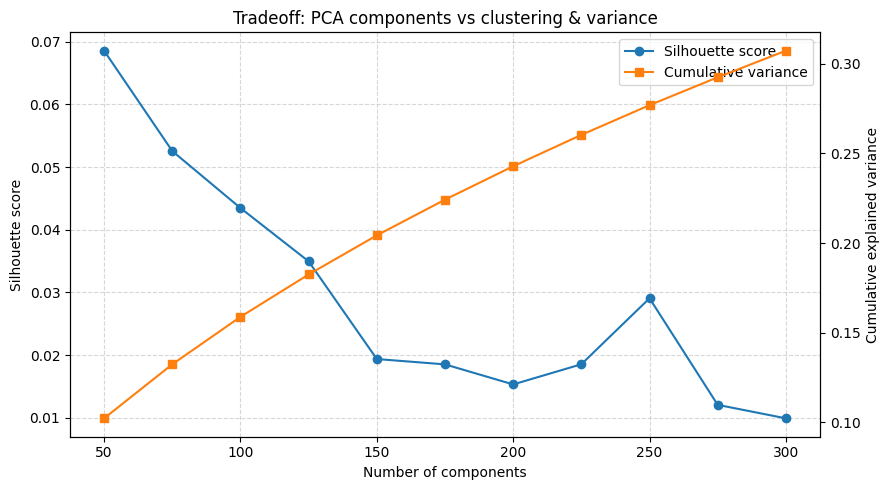

In [10]:
import numpy as np
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import pandas as pd
import matplotlib.pyplot as plt


components_to_test = [50, 75, 100, 125, 150, 175, 200, 225, 250, 275, 300]
n_clusters = 10
max_sil_samples = 5000   # subsample for silhouette to keep it fast

results = []

for n_comp in components_to_test:
    print(f"\n=== Testing {n_comp} components ===")

    svd = TruncatedSVD(n_components=n_comp, random_state=42)
    X_red = svd.fit_transform(X_tfidf)

    cum_var = svd.explained_variance_ratio_.sum()
    print(f"Cumulative explained variance: {cum_var:.4f}")

    # K-means on reduced data
    km = KMeans(n_clusters=n_clusters, n_init=10, random_state=42)
    labels = km.fit_predict(X_red)

    # Subsample for silhouette (it’s O(n^2))
    if X_red.shape[0] > max_sil_samples:
        idx = np.random.choice(X_red.shape[0], max_sil_samples, replace=False)
        sil = silhouette_score(X_red[idx], labels[idx])
    else:
        sil = silhouette_score(X_red, labels)

    print(f"Silhouette score: {sil:.4f}")

    results.append({
        "n_components": n_comp,
        "cum_explained_var": cum_var,
        "silhouette": sil
    })

results_df = pd.DataFrame(results)
display(results_df)

# plot the tradeoff
fig, ax1 = plt.subplots(figsize=(9,5))

ax1.plot(results_df["n_components"], results_df["silhouette"],
         marker="o", label="Silhouette score")
ax1.set_xlabel("Number of components")
ax1.set_ylabel("Silhouette score")
ax1.grid(True, linestyle="--", alpha=0.5)

ax2 = ax1.twinx()
ax2.plot(results_df["n_components"], results_df["cum_explained_var"],
         marker="s", color="tab:orange", label="Cumulative variance")
ax2.set_ylabel("Cumulative explained variance")

# Combine legends
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc="best")

plt.title("Tradeoff: PCA components vs clustering & variance")
plt.tight_layout()
plt.savefig(f"{FIGURE_SAVE_PATH}/pca_ncomponent_tradeoff.png")
plt.show()


#### PCA Preprocess Pipeline

In [11]:
# PCA Feature Pipeline

# Check if PCA columns already exist and drop them so we don't get duplicates
cols_to_drop = [c for c in sampled_df.columns if c.startswith('pca_') or c == 'cluster']
sampled_df = sampled_df.drop(columns=cols_to_drop, errors='ignore')

from sklearn.decomposition import PCA

# Run PCA
OPTIMAL_N_COMPONENT = 50
# See above plot to find the optimal n_components
pca = PCA(n_components=OPTIMAL_N_COMPONENT)
X_pca = pca.fit_transform(X_tfidf.toarray())

# Create a df from PCA results and attach it to sampled_df
pca_cols = [f"pca_{i}" for i in range(50)]
pca_df = pd.DataFrame(X_pca, columns=pca_cols)
sampled_df = pd.concat([sampled_df, pca_df], axis=1)

# Author and Venue Embeddings
# Venue embeddings
venue_emb = sampled_df.groupby("venue")[pca_cols].mean()

# Author embeddings
authors_exploded = []
authors_emb = []
authors_exploded = sampled_df.explode('authors')
author_emb = authors_exploded.groupby('authors')[pca_cols].mean()

#### Generate Interpretable Features
These are the metadata features for trend analysis and network analysis

In [12]:
# Number of Authors (Collaboration Size)
sampled_df['num_authors'] = sampled_df['authors'].apply(lambda x: len(x) if isinstance(x, list) else 0)

# Title Length (Character Count)
sampled_df['title_length'] = sampled_df['title'].apply(lambda x: len(str(x)))

# Number of References (How many papers this paper cites)
sampled_df['num_refs'] = sampled_df['references'].apply(lambda x: len(x) if isinstance(x, list) else 0)

# Citation Velocity (Citations per year)
sampled_df['citation_velocity'] = sampled_df['n_citation'] / (2018 - sampled_df['year'].astype(int) + 1)
print(sampled_df['citation_velocity'].max())

# Change the types as well to reduce memory
as_type = {
    "num_authors": "category",
    "title_length": np.uint16,
    "num_refs": np.uint8,
    "citation_velocity": np.float32,
}

sampled_df[["title", 'year', 'num_authors', 'num_refs', 'citation_velocity']].head()

870.3076923076923


,title,year,num_authors,num_refs,citation_velocity
0,a note on the entscheidungsproblem,1936,1,0,11.433735
1,toward a calculus of concepts,1936,1,0,0.228916
2,constructibility as a criterion for existence,1936,1,0,0.012048
3,correction to a note on the entscheidungsproblem,1936,1,1,1.807229
4,finite combinatory processes--formulation 1,1936,1,0,4.421687


### EDA Validation for our cleaned sampled dataset

To see if our preprocessing pipeline generated quality data

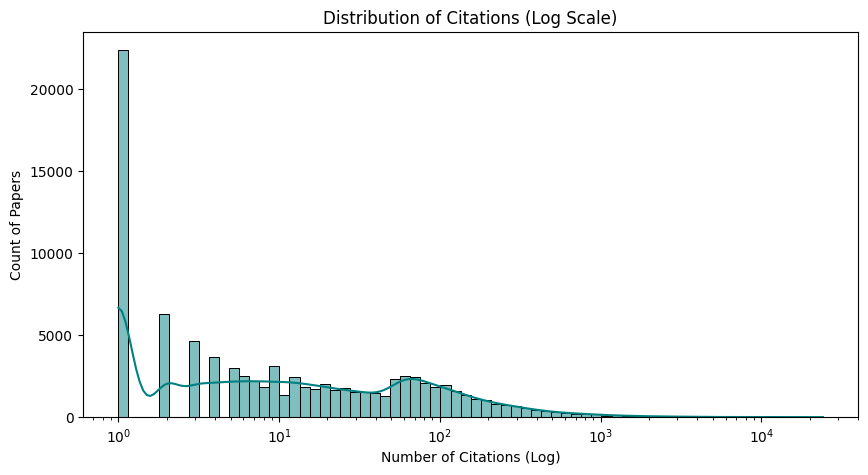

/var/folders/75/qzfw3nr90j3_7wzdxhpqh5vm0000gn/T/ipykernel_35894/3985746004.py:18: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  auth_trend = sampled_df.groupby('year')['num_authors'].mean().reset_index()


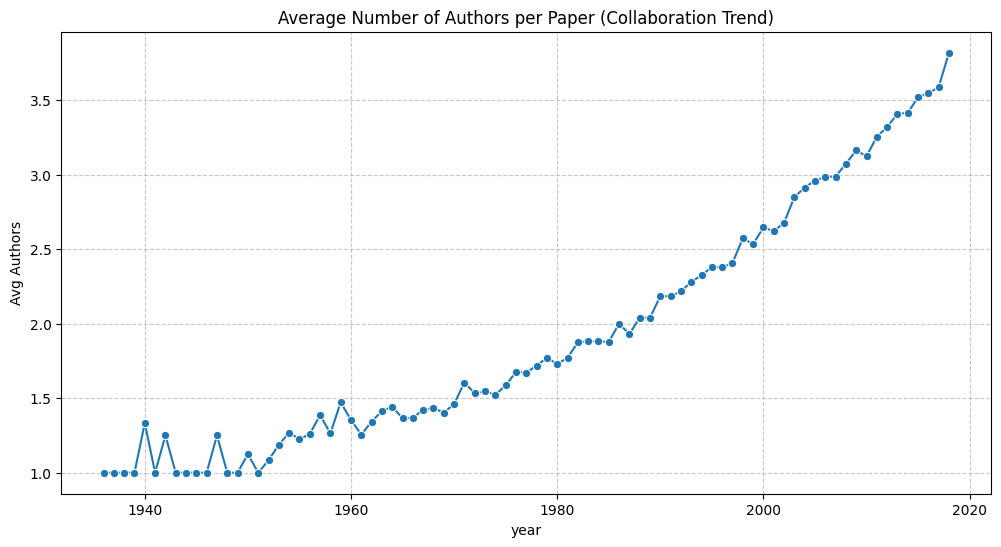

/var/folders/75/qzfw3nr90j3_7wzdxhpqh5vm0000gn/T/ipykernel_35894/3985746004.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y='venue', data=sampled_df[sampled_df['venue'].isin(top_venues)], order=top_venues, palette='viridis')


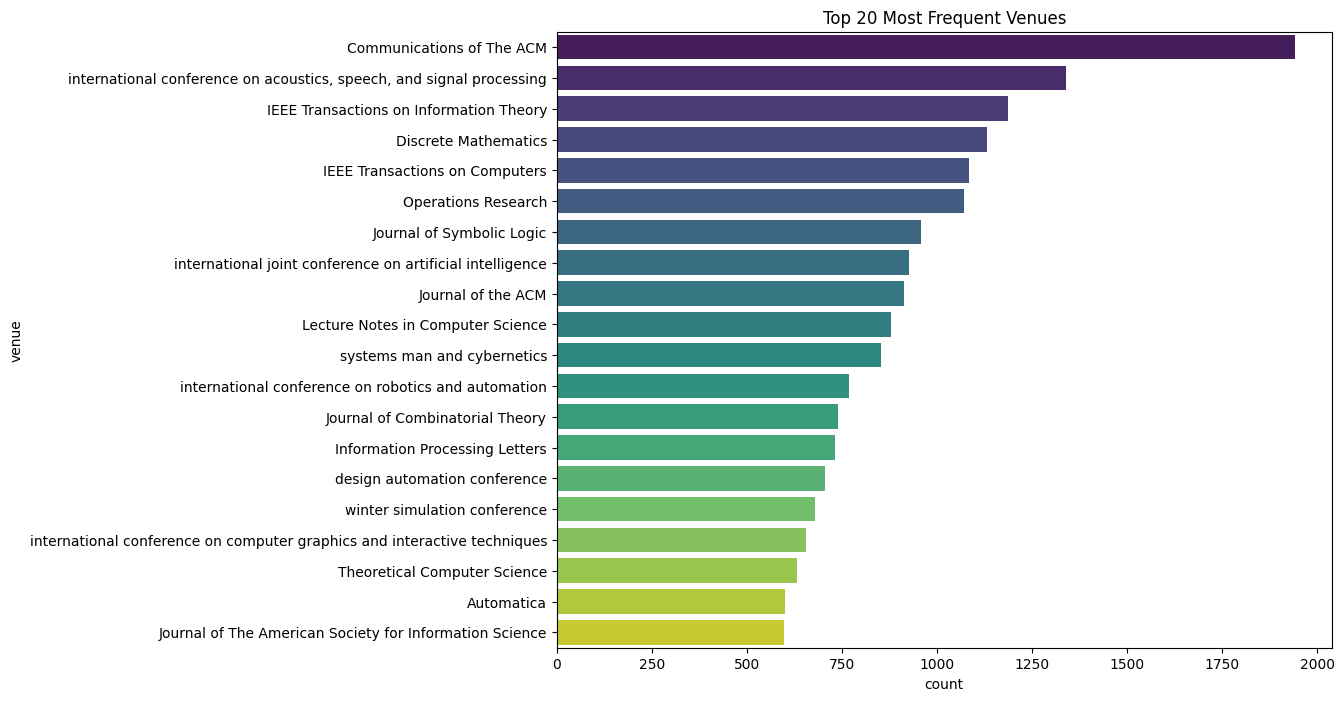

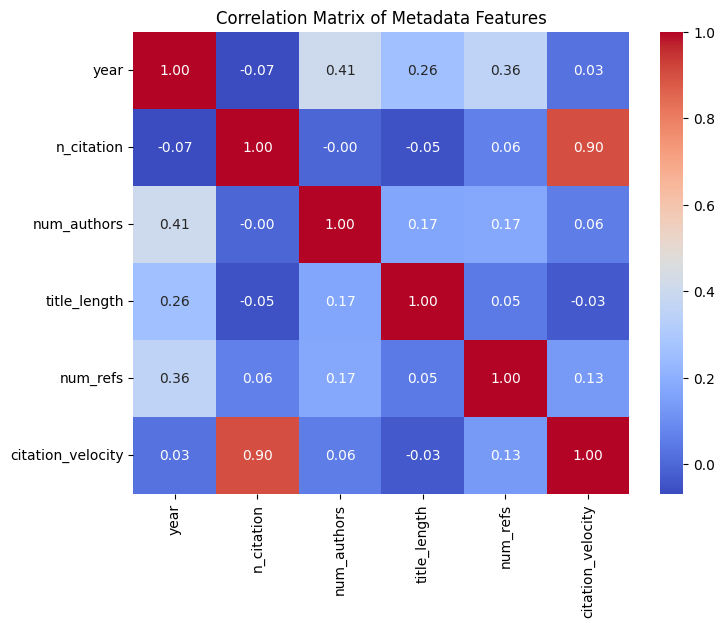

                       year  n_citation  num_authors  title_length  num_refs  \
year               1.000000   -0.067886     0.405191      0.259450  0.355012   
n_citation        -0.067886    1.000000    -0.001815     -0.054687  0.061692   
num_authors        0.405191   -0.001815     1.000000      0.168474  0.174373   
title_length       0.259450   -0.054687     0.168474      1.000000  0.046123   
num_refs           0.355012    0.061692     0.174373      0.046123  1.000000   
citation_velocity  0.026561    0.902957     0.055096     -0.031083  0.132368   

                   citation_velocity  
year                        0.026561  
n_citation                  0.902957  
num_authors                 0.055096  
title_length               -0.031083  
num_refs                    0.132368  
citation_velocity           1.000000  


In [13]:
# The "Power Law" Check (Citation Distribution)
# See https://link.springer.com/article/10.1007/s100510050359
# This is now done above in the preprocessing check
# Preprocessed above to remove n_citation = 50 outlier
# ARTIFACT_VAL = 50
# clean_df = sampled_df[sampled_df['n_citation'] != ARTIFACT_VAL]

plt.figure(figsize=(10,5))
sns.histplot(sampled_df['n_citation'] + 1, log_scale=True, kde=True, color='teal')
plt.title('Distribution of Citations (Log Scale)')
plt.xlabel('Number of Citations (Log)')
plt.ylabel('Count of Papers')
plt.savefig(f"{FIGURE_SAVE_PATH}/eda_citation_distribution.png")
plt.show()

plt.figure(figsize=(12, 6))
# Group by year and get mean authors
auth_trend = sampled_df.groupby('year')['num_authors'].mean().reset_index()
sns.lineplot(data=auth_trend, x='year', y='num_authors', marker='o')
plt.title('Average Number of Authors per Paper (Collaboration Trend)')
plt.ylabel('Avg Authors')
plt.grid(True, linestyle='--', alpha=0.7)
plt.savefig(f"{FIGURE_SAVE_PATH}/eda_collaboration_trend.png")
plt.show()

plt.figure(figsize=(10, 8))
# Get top 20 venues
top_venues = sampled_df['venue'].value_counts().nlargest(20).index
# Filter data to only those venues for plotting
sns.countplot(y='venue', data=sampled_df[sampled_df['venue'].isin(top_venues)], order=top_venues, palette='viridis')
plt.title('Top 20 Most Frequent Venues')
plt.savefig(f"{FIGURE_SAVE_PATH}/eda_top_venues.png")
plt.show()



# Select only numeric metadata
meta_cols = ['year', 'n_citation', 'num_authors', 'title_length', 'num_refs', 'citation_velocity']

plt.figure(figsize=(8, 6))
sns.heatmap(sampled_df[meta_cols].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Metadata Features')
plt.savefig(f"{FIGURE_SAVE_PATH}/eda_corr_matrix.png")
plt.show()

print(sampled_df[meta_cols].corr())

## Task 2: Topic Clustering

#### K-Means Pipeline

Run clustering and name the topics

In [ ]:
import numpy as np
from sklearn.cluster import KMeans

OPTIMAL_K = 8 # We chose this k for interpretability

# Fit Final Model
print(f"Clustering into {OPTIMAL_K} topics...")
# Use X_pca for the clustering itself (efficient)
kmeans = KMeans(n_clusters=OPTIMAL_K, random_state=42, n_init=10)
sampled_df['cluster'] = kmeans.fit_predict(X_pca)

# Interpret Clusters (Keyword Extraction)
print("Extracting top keywords for each topic...")

# We need the original TF-IDF vocabulary to convert numbers back to words
feature_names = tfidf.get_feature_names_out()

# Group papers by cluster
for i in range(OPTIMAL_K):
    # Get the indices of papers in this cluster
    cluster_indices = sampled_df[sampled_df['cluster'] == i].index

    # Calculate the AVERAGE TF-IDF vector for this cluster
    # (We use the X_tfidf matrix from Task 1, slicing by the cluster's rows)
    cluster_center = X_tfidf[cluster_indices].mean(axis=0)

    # Convert matrix to 1D array
    cluster_center_arr = np.asarray(cluster_center).flatten()

    # Get indices of the top 10 highest weighted words
    top_indices = cluster_center_arr.argsort()[::-1][:10]

    # Map indices to words
    top_keywords = [feature_names[ind] for ind in top_indices]

    print(f"\n--- Cluster {i} ({len(cluster_indices)} papers) ---")
    print(f"Keywords: {', '.join(top_keywords)}")
    # Show a sample title to verify
    print(f"Sample Title: {sampled_df[sampled_df['cluster'] == i]['title'].iloc[0]}")

For report:

Unsupervised clustering revealed a distinct group of non-english papers (cluster 1). We utilized this insight to filter the dataset, removing 186 foreign language documents to improve downstream topic modeling


Important: ONlY RUN THIS ONCE TO REMOVE THE GERMAN PAPERS!

Now we remove cluster x and rerun the pipeline

Re run TF-IDF -> PCA -> K-means pipeline

In [ ]:
# Verify the german cluster index
sampled_df[sampled_df['cluster'] == 6]

In [ ]:
german_cluster_id = 6
print(f"Removing {len(sampled_df[sampled_df['cluster'] == german_cluster_id])} non-English papers...")

sampled_df = sampled_df[sampled_df['cluster'] != german_cluster_id].copy()

sampled_df = sampled_df.reset_index(drop=True)

Visualize the clusters with new human-readable labels you might need to change the cluster_names list see above for the output result

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Update cluster names based on the output we get above
cluster_names = {
    0: 'Numerical Computing',      # matrix, inversion, polynomial
    1: 'General Modeling & Logic', # (The large catch-all cluster)
    2: 'Robotics & Control',       # robot, controller, manipulator
    3: 'Optimization & Theory',    # linear programming, equations
    4: 'Software & Info Systems',  # language, software, user, design
    5: 'Graph Theory',             # vertices, edge, connected
    6: 'Networking & Wireless',    # wireless, routing, protocol
    7: 'Editorial/Historical'      # letters to editor, algol, acm
}

# Apply mapping
sampled_df['label'] = sampled_df['cluster'].map(cluster_names)

# 3. Plot
plt.figure(figsize=(12, 8))
sns.scatterplot(
    x='pca_0',
    y='pca_1',
    hue='label',
    data=sampled_df,
    palette='tab10',
    alpha=0.9,
    s=60             # Marker size
)
plt.title('DBLP Research Landscape: Topic Clusters', fontsize=15)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='Research Topic')
plt.tight_layout()
plt.savefig(f"{FIGURE_SAVE_PATH}/topic_clustering_pca.png")
plt.show()

In [ ]:
from sklearn.manifold import TSNE

print("Running t-SNE to visualize clusters (this takes a moment)...")

# We use the same X_pca data, but project it differently
tsne = TSNE(n_components=2, verbose=1, perplexity=40, random_state=42)
tsne_results = tsne.fit_transform(X_pca)

# Add t-SNE results to the dataframe
sampled_df['tsne_x'] = tsne_results[:, 0]
sampled_df['tsne_y'] = tsne_results[:, 1]

# Plotting the t-SNE result
plt.figure(figsize=(12, 8))
sns.scatterplot(
    x='tsne_x',
    y='tsne_y',
    hue='label',
    data=sampled_df,
    palette='tab10', # Stronger colors
    alpha=0.7,
    s=40,
    legend='full'
)

plt.title('t-SNE Visualization of Research Topics', fontsize=16)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig(f"{FIGURE_SAVE_PATH}/topic_clustering_t-SNE.png")
plt.show()

## Task 3: Temporal Trend Analysis

In [15]:
# identify PCA columns
pca_cols = [col for col in sampled_df.columns if col.startswith('pca_')]

# clustering using KMeans
OPTIMAL_K = 8  # Choose an optimal K based on prior analysis
kmeans = KMeans(n_clusters=OPTIMAL_K, random_state=42, n_init=10)
sampled_df['cluster'] = kmeans.fit_predict(sampled_df[pca_cols])

In [16]:
# map cluster names based on prior interpretation
cluster_names = {
    0: 'Numerical Computing',      # matrix, inversion, polynomial
    1: 'General Modeling & Logic', # (The large catch-all cluster)
    2: 'Robotics & Control',       # robot, controller, manipulator
    3: 'Optimization & Theory',    # linear programming, equations
    4: 'Software & Info Systems',  # language, software, user, design
    5: 'Graph Theory',             # vertices, edge, connected
    6: 'Networking & Wireless',    # wireless, routing, protocol
    7: 'Editorial/Historical'      # letters to editor, algol, acm
}

sampled_df['label'] = sampled_df['cluster'].map(cluster_names)

In [17]:
# build temporal trend data
trend = sampled_df.groupby(['year', 'label']).size().rename('count').reset_index()

# normalize by year totals
year_totals = trend.groupby('year')['count'].sum().rename('year_total')
trend = trend.merge(year_totals, on='year')
trend["share"] = trend["count"] / trend["year_total"]

/var/folders/75/qzfw3nr90j3_7wzdxhpqh5vm0000gn/T/ipykernel_35894/3056517717.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  trend = sampled_df.groupby(['year', 'label']).size().rename('count').reset_index()
/var/folders/75/qzfw3nr90j3_7wzdxhpqh5vm0000gn/T/ipykernel_35894/3056517717.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  year_totals = trend.groupby('year')['count'].sum().rename('year_total')


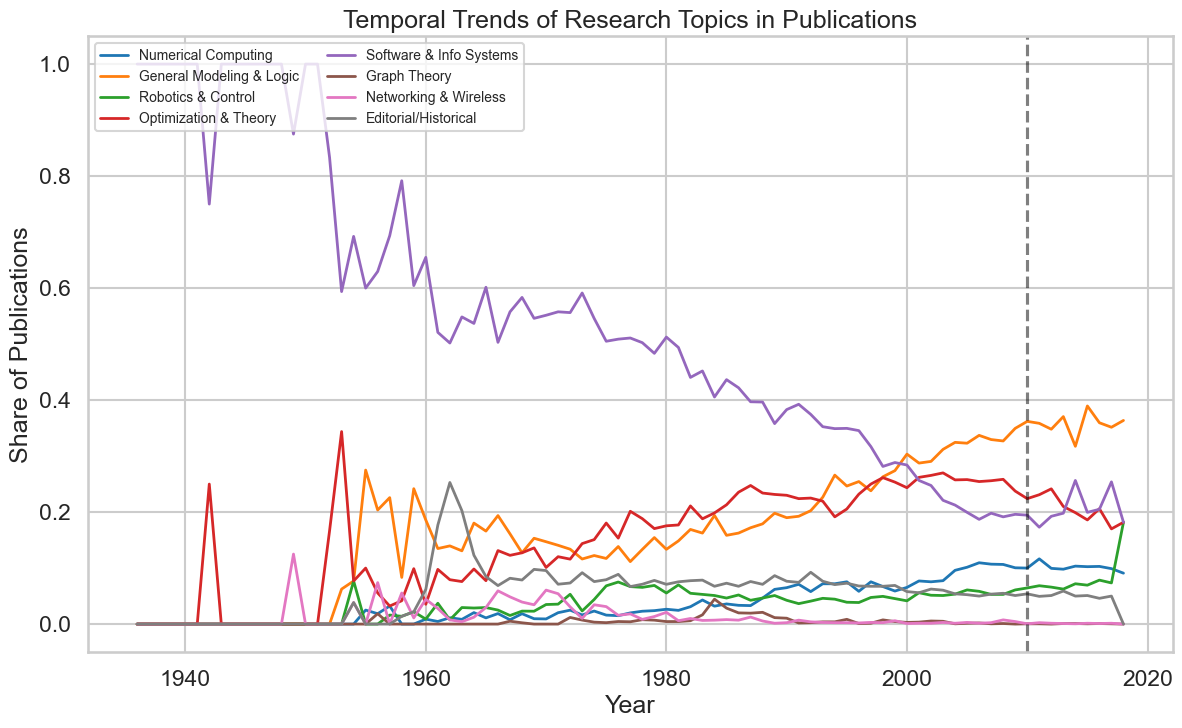

<Figure size 640x480 with 0 Axes>

In [18]:
# visualization of trends
sns.set(style="whitegrid", context="talk", palette="tab10")

plt.figure(figsize=(14, 8))
for label in cluster_names.values():
    sub = trend[trend["label"] == label].sort_values("year")
    plt.plot(sub["year"], sub["share"], label=label, linewidth=2)

plt.axvline(2010, color="k", linestyle="--", alpha=0.5)
plt.title("Temporal Trends of Research Topics in Publications")
plt.xlabel("Year")
plt.ylabel("Share of Publications")
plt.legend(loc="upper left", ncol=2, fontsize=10, frameon=True)
plt.show()
plt.savefig(f"{FIGURE_SAVE_PATH}/temporal_trends.png")
plt.show()

In [ ]:
# summary table for rise and fall of each topic over time
summary = (
    trend.assign(period=trend['year'].apply(lambda y: 'Pre-2010' if int(y) < 2010 else 'Post-2010'))
    .groupby(['label', 'period'])['share']
    .mean()
    .unstack()
    .reset_index()
)

print(summary)

period                     label  Post-2010  Pre-2010
0           Editorial/Historical   0.045611  0.055779
1       General Modeling & Logic   0.357848  0.152326
2                   Graph Theory   0.000556  0.004317
3          Networking & Wireless   0.001111  0.014006
4            Numerical Computing   0.101434  0.031690
5          Optimization & Theory   0.205480  0.143787
6             Robotics & Control   0.081869  0.032248
7        Software & Info Systems   0.206091  0.565847


## Task 4: Predictive Modeling (Classification)

## Task 5: Network Analysis